## Part 1: Metadata Retrieval and Analysis from PanKbase API

### A. Query Analysis Set and Extract Linked Measurement Sets

Use case 1: Reference map of islet cell type-specific chromatin accessibility from 97,659 cells derived from single cell ATAC-seq assays of 41 non-diabetic;T1D autoantibody positive (Aab+);T1D;and T2D donors from the Human Pancreas Analysis Program

https://data.pankbase.org/analysis-sets/PKBDS0470WCHR/


### User Configuration & Setup

In [1]:
# === USER CONFIGURATION VARIABLES ===
# Modify these values to customize your analysis
ANALYSIS_SET_ID <- "PKBDS0470WCHR"     # Dataset ID to analyze
PLOT_THEME <- "minimal"                # Plot theme: minimal, bw, classic, void
COLOR_PALETTE <- "Set2"                # Color palette: Set1, Set2, Dark2, Pastel1
HISTOGRAM_BINS <- 15                   # Number of bins for histograms
PLOT_ALPHA <- 0.7                      # Transparency for plots (0-1)
PLOT_SIZE <- 3                         # Point size for scatter plots
SHOW_PROGRESS <- TRUE                  # Show progress messages during data loading
MAX_RETRIES <- 3                       # Max API retry attempts
TIMEOUT_SECONDS <- 30                  # API timeout in seconds

# Advanced options
INCLUDE_CORRELATIONS <- TRUE           # Calculate and display correlations
FILTER_INCOMPLETE_DATA <- FALSE        # Remove samples with missing key data
MIN_SAMPLE_SIZE <- 1                   # Minimum samples per group for analysis

# === DEFAULTS (DO NOT MODIFY - automatic fallbacks) ===
ANALYSIS_SET_ID <- ifelse(exists("ANALYSIS_SET_ID") && !is.null(ANALYSIS_SET_ID), ANALYSIS_SET_ID, "PKBDS0470WCHR")
PLOT_THEME <- ifelse(exists("PLOT_THEME") && !is.null(PLOT_THEME), PLOT_THEME, "minimal")
COLOR_PALETTE <- ifelse(exists("COLOR_PALETTE") && !is.null(COLOR_PALETTE), COLOR_PALETTE, "Set2")
HISTOGRAM_BINS <- ifelse(exists("HISTOGRAM_BINS") && !is.null(HISTOGRAM_BINS), HISTOGRAM_BINS, 15)
PLOT_ALPHA <- ifelse(exists("PLOT_ALPHA") && !is.null(PLOT_ALPHA), PLOT_ALPHA, 0.7)
PLOT_SIZE <- ifelse(exists("PLOT_SIZE") && !is.null(PLOT_SIZE), PLOT_SIZE, 3)
SHOW_PROGRESS <- ifelse(exists("SHOW_PROGRESS") && !is.null(SHOW_PROGRESS), SHOW_PROGRESS, TRUE)
MAX_RETRIES <- ifelse(exists("MAX_RETRIES") && !is.null(MAX_RETRIES), MAX_RETRIES, 3)
TIMEOUT_SECONDS <- ifelse(exists("TIMEOUT_SECONDS") && !is.null(TIMEOUT_SECONDS), TIMEOUT_SECONDS, 30)
INCLUDE_CORRELATIONS <- ifelse(exists("INCLUDE_CORRELATIONS") && !is.null(INCLUDE_CORRELATIONS), INCLUDE_CORRELATIONS, TRUE)
FILTER_INCOMPLETE_DATA <- ifelse(exists("FILTER_INCOMPLETE_DATA") && !is.null(FILTER_INCOMPLETE_DATA), FILTER_INCOMPLETE_DATA, FALSE)
MIN_SAMPLE_SIZE <- ifelse(exists("MIN_SAMPLE_SIZE") && !is.null(MIN_SAMPLE_SIZE), MIN_SAMPLE_SIZE, 1)

# Display configuration
cat("=== ANALYSIS CONFIGURATION ===\n")
cat("Dataset ID:", ANALYSIS_SET_ID, "\n")
cat("Plot theme:", PLOT_THEME, "\n")
cat("Color palette:", COLOR_PALETTE, "\n")
cat("Histogram bins:", HISTOGRAM_BINS, "\n")
cat("Plot transparency:", PLOT_ALPHA, "\n")
cat("Include correlations:", INCLUDE_CORRELATIONS, "\n")
cat("=====================================\n\n")

# Install and load required packages
required_packages <- c("httr", "jsonlite", "dplyr", "ggplot2", "readr", 
                      "RColorBrewer", "gridExtra", "knitr", "viridis")

missing_packages <- required_packages[!required_packages %in% installed.packages()[,"Package"]]
if(length(missing_packages) > 0) {
  cat("Installing missing packages:", paste(missing_packages, collapse = ", "), "\n")
  install.packages(missing_packages)
}

# Load libraries with suppressed messages
suppressMessages({
  for(pkg in required_packages) {
    library(pkg, character.only = TRUE)
  }
})

# Set plot theme based on user preference
plot_theme_func <- switch(PLOT_THEME,
  "minimal" = theme_minimal(),
  "bw" = theme_bw(), 
  "classic" = theme_classic(),
  "void" = theme_void(),
  theme_minimal() # default fallback
)

theme_set(plot_theme_func + theme(plot.title = element_text(hjust = 0.5)))

cat("Libraries loaded and theme set successfully!\n")

=== ANALYSIS CONFIGURATION ===
Dataset ID: PKBDS0470WCHR 
Plot theme: minimal 
Color palette: Set2 
Histogram bins: 15 
Plot transparency: 0.7 
Include correlations: TRUE 

Libraries loaded and theme set successfully!


### API Setup & Helper Functions

In [2]:
# Base URLs and configuration
base_url <- "https://api.data.pankbase.org"
analysis_set_id <- ANALYSIS_SET_ID
analysis_url <- paste0(base_url, "/analysis-sets/", analysis_set_id, "/")

# Enhanced API query function with user-configurable options
safe_api_query <- function(url, retries = MAX_RETRIES, timeout = TIMEOUT_SECONDS) {
  for(attempt in 1:retries) {
    tryCatch({
      if(SHOW_PROGRESS && attempt > 1) {
        cat("  Retry attempt", attempt, "for:", url, "\n")
      }
      
      response <- GET(url, timeout(timeout))
      if (status_code(response) == 200) {
        return(fromJSON(content(response, "text", encoding = "UTF-8")))
      } else {
        warning(paste("API request failed for:", url, "Status:", status_code(response)))
        if(attempt == retries) return(NULL)
      }
    }, error = function(e) {
      warning(paste("Error querying:", url, "-", e$message))
      if(attempt == retries) return(NULL)
      Sys.sleep(1) # Wait before retry
    })
  }
  return(NULL)
}

# Helper functions
extract_donor_accession <- function(sample_data) {
  if (!is.null(sample_data$donors) && length(sample_data$donors) > 0) {
    donor_url <- sample_data$donors[[1]]
    if (is.character(donor_url)) {
      return(basename(donor_url))
    } else if (is.list(donor_url) && "accession" %in% names(donor_url)) {
      return(donor_url$accession)
    }
  }
  return(NA)
}

safe_extract <- function(data, field, default = NA) {
  if (field %in% names(data) && !is.null(data[[field]])) {
    return(data[[field]])
  }
  return(default)
}

extract_sample_accessions <- function(samples_data) {
  sample_accessions <- c()
  
  if (is.list(samples_data)) {
    for (sample in samples_data) {
      if (is.list(sample)) {
        if ("accession" %in% names(sample)) {
          accession <- sample$accession
          if (is.character(accession) && length(accession) == 1) {
            if (grepl("^PKBSM", accession)) {
              sample_accessions <- c(sample_accessions, accession)
            }
          }
        }
      } else if (is.character(sample)) {
        accession <- basename(sample)
        if (grepl("^PKBSM", accession)) {
          sample_accessions <- c(sample_accessions, accession)
        }
      }
    }
  }
  
  return(unique(sample_accessions))
}

cat("API functions configured successfully!\n")
cat("Using timeout:", TIMEOUT_SECONDS, "seconds\n")
cat("Max retries:", MAX_RETRIES, "\n")

API functions configured successfully!
Using timeout: 30 seconds
Max retries: 3 


### Query Analysis Set & Extract Measurement Sets 

In [ ]:
# Query the analysis set
if(SHOW_PROGRESS) cat("Querying analysis set:", analysis_url, "\n")

analysis_data <- safe_api_query(analysis_url)
if (!is.null(analysis_data)) {
  cat("Successfully retrieved analysis set data\n")
  cat("Description:", analysis_data$description, "\n")
} else {
  stop("Failed to retrieve analysis set data")
}

# Enhanced measurement set extraction with multiple methods
cat("\n=== Extracting measurement sets (Enhanced Method) ===\n")

measurement_set_accessions <- c()

# Method 1: Check input_file_sets
if ("input_file_sets" %in% names(analysis_data) && is.list(analysis_data$input_file_sets)) {
  if(SHOW_PROGRESS) cat("Checking input_file_sets...\n")
  
  for (i in seq_along(analysis_data$input_file_sets)) {
    file_set <- analysis_data$input_file_sets[[i]]
    
    if(SHOW_PROGRESS) cat("  Processing input file set", i, "\n")
    
    if (is.list(file_set)) {
      # Direct accession field
      if ("accession" %in% names(file_set)) {
        accession <- file_set$accession
        if (is.character(accession) && grepl("^PKBDS", accession)) {
          measurement_set_accessions <- c(measurement_set_accessions, accession)
          if(SHOW_PROGRESS) cat("    ✓ Found accession:", accession, "\n")
        }
      }
      
      # Extract from @id field
      if ("@id" %in% names(file_set)) {
        id_path <- file_set$`@id`
        if (is.character(id_path) && grepl("/measurement-sets/", id_path)) {
          accession <- gsub(".*/measurement-sets/([^/]+)/?.*", "\\1", id_path)
          if (grepl("^PKBDS", accession)) {
            measurement_set_accessions <- c(measurement_set_accessions, accession)
            if(SHOW_PROGRESS) cat("    ✓ Extracted from @id:", accession, "\n")
          }
        }
      }
    }
  }
}

# Method 2: Search all fields for measurement set references
if (length(measurement_set_accessions) == 0) {
  if(SHOW_PROGRESS) cat("Searching all fields for measurement set references...\n")
  
  # Recursive function to search nested structures
  extract_accessions_recursive <- function(obj, depth = 0) {
    accessions <- c()
    if (depth > 5) return(accessions) # Prevent infinite recursion
    
    if (is.list(obj)) {
      for (item in obj) {
        accessions <- c(accessions, extract_accessions_recursive(item, depth + 1))
      }
    } else if (is.character(obj)) {
      # Look for measurement set patterns
      if (grepl("/measurement-sets/PKBDS", obj)) {
        acc <- gsub(".*/measurement-sets/([^/]+)/?.*", "\\1", obj)
        if (grepl("^PKBDS", acc)) {
          accessions <- c(accessions, acc)
        }
      } else if (grepl("^PKBDS", obj) && nchar(obj) > 8 && nchar(obj) < 20) {
        # Direct accession pattern
        accessions <- c(accessions, obj)
      }
    }
    return(unique(accessions))
  }
  
  found_accessions <- extract_accessions_recursive(analysis_data)
  measurement_set_accessions <- c(measurement_set_accessions, found_accessions)
  
  if(length(found_accessions) > 0) {
    if(SHOW_PROGRESS) cat("  ✓ Found", length(found_accessions), "accessions via recursive search\n")
  }
}

# Method 3: Try search API as fallback
if (length(measurement_set_accessions) == 0) {
  if(SHOW_PROGRESS) cat("🔍 Using search API fallback...\n")
  
  search_url <- paste0(base_url, "/search/?type=MeasurementSet&limit=20")
  search_results <- safe_api_query(search_url)
  
  if (!is.null(search_results) && "data" %in% names(search_results)) {
    for (result in search_results$data) {
      if (is.list(result) && "accession" %in% names(result)) {
        measurement_set_accessions <- c(measurement_set_accessions, result$accession)
        if (length(measurement_set_accessions) >= 5) break # Limit fallback
      }
    }
    if(SHOW_PROGRESS) cat("  ✓ Found", length(measurement_set_accessions), "measurement sets via search fallback\n")
  }
}

# Remove duplicates and validate
measurement_set_accessions <- unique(measurement_set_accessions)
measurement_set_accessions <- measurement_set_accessions[grepl("^PKBDS", measurement_set_accessions)]

cat("\n EXTRACTION RESULTS:\n")
cat("Found", length(measurement_set_accessions), "measurement set accessions\n")

if (length(measurement_set_accessions) > 0) {
  if(SHOW_PROGRESS) {
    cat("Measurement sets to process:\n")
    for(i in seq_along(measurement_set_accessions)) {
      cat("  ", i, ":", measurement_set_accessions[i], "\n")
    }
  }
} else {
  cat(" No measurement set accessions found.\n")
  cat("Available fields in analysis_data:\n")
  print(names(analysis_data))
  stop("Cannot proceed without measurement set accessions")
}

### Load Metadata

In [ ]:
# Initialize data storage
donor_data_list <- list()
sample_data_list <- list()
measurement_data_list <- list()

cat(" Starting metadata collection...\n")
start_time <- Sys.time()

# Progress tracking
total_ms <- length(measurement_set_accessions)
processed_ms <- 0

for (i in seq_along(measurement_set_accessions)) {
  ms_accession <- measurement_set_accessions[i]
  
  if(SHOW_PROGRESS) cat("\n Processing measurement set", i, "of", total_ms, ":", ms_accession, "\n")
  
  # Query measurement set
  ms_url <- paste0(base_url, "/measurement-sets/", ms_accession, "/")
  ms_data <- safe_api_query(ms_url)
  
  if (!is.null(ms_data)) {
    measurement_data_list[[ms_accession]] <- ms_data
    
    # Extract sample accessions
    if (!is.null(ms_data$samples) && length(ms_data$samples) > 0) {
      sample_accessions <- extract_sample_accessions(ms_data$samples)
      
      if (length(sample_accessions) > 0) {
        if(SHOW_PROGRESS) cat("  ├─ Found", length(sample_accessions), "samples\n")
        
        # Query each sample
        for (j in seq_along(sample_accessions)) {
          sample_accession <- sample_accessions[j]
          
          if (!sample_accession %in% names(sample_data_list)) {
            sample_url <- paste0(base_url, "/primary-islet/", sample_accession, "/")
            sample_data <- safe_api_query(sample_url)
            
            if (!is.null(sample_data)) {
              sample_data_list[[sample_accession]] <- sample_data
              
              # Extract and query donor
              donor_accession <- extract_donor_accession(sample_data)
              if (!is.na(donor_accession) && !donor_accession %in% names(donor_data_list)) {
                donor_url <- paste0(base_url, "/human-donors/", donor_accession, "/")
                donor_data <- safe_api_query(donor_url)
                
                if (!is.null(donor_data)) {
                  donor_data_list[[donor_accession]] <- donor_data
                  if(SHOW_PROGRESS) cat("  ├─ Sample", j, "→ Donor", donor_accession, "\n")
                }
              }
            }
          }
        }
      }
    }
  }
  
  processed_ms <- processed_ms + 1
  
  # Progress update
  if (processed_ms %% max(1, floor(total_ms/4)) == 0) {
    elapsed <- as.numeric(difftime(Sys.time(), start_time, units = "secs"))
    cat("\n Progress: ", round(100 * processed_ms/total_ms, 1), "% complete\n")
    cat("   Elapsed time:", round(elapsed, 1), "seconds\n")
    cat("   Current totals: ", length(donor_data_list), "donors,", length(sample_data_list), "samples\n")
  }
}

end_time <- Sys.time()
total_time <- as.numeric(difftime(end_time, start_time, units = "secs"))

cat("\nDATA COLLECTION COMPLETE!\n")
cat("Final counts:\n")
cat("   • Donors:", length(donor_data_list), "\n")
cat("   • Samples:", length(sample_data_list), "\n") 
cat("   • Measurement sets:", length(measurement_data_list), "\n")
cat("Total collection time:", round(total_time, 1), "seconds\n")

### Process Donor Metadata

In [12]:
# Extract donor metadata
cat(" Processing donor metadata...\n")

donor_metadata <- data.frame(
  donor_accession = names(donor_data_list),
  stringsAsFactors = FALSE
)

# Extract all donor fields
for (i in seq_along(donor_data_list)) {
  donor <- donor_data_list[[i]]
  
  donor_metadata$age[i] <- safe_extract(donor, "age")
  donor_metadata$bmi[i] <- safe_extract(donor, "bmi") 
  donor_metadata$sex[i] <- safe_extract(donor, "sex")
  donor_metadata$hba1c[i] <- safe_extract(donor, "hba1c")
  donor_metadata$diabetes_status_description[i] <- safe_extract(donor, "diabetes_status_description")
  donor_metadata$ethnicity[i] <- ifelse(!is.null(donor$ethnicities) && length(donor$ethnicities) > 0, 
                                       donor$ethnicities[1], NA)
  donor_metadata$cause_of_death[i] <- safe_extract(donor, "cause_of_death")
  donor_metadata$c_peptide[i] <- safe_extract(donor, "c_peptide")
}

# Convert numeric columns
numeric_cols <- c("age", "bmi", "hba1c", "c_peptide")
donor_metadata[numeric_cols] <- lapply(donor_metadata[numeric_cols], as.numeric)

# Apply filtering if requested
if(FILTER_INCOMPLETE_DATA) {
  initial_count <- nrow(donor_metadata)
  donor_metadata <- donor_metadata[complete.cases(donor_metadata[c("age", "bmi", "sex")]), ]
  cat(" Filtered donors: ", initial_count, "→", nrow(donor_metadata), "(removed", initial_count - nrow(donor_metadata), "with missing key data)\n")
}

# Display summary
cat(" Donor Metadata Summary:\n")
print(summary(donor_metadata[numeric_cols]))

cat("\n Categorical data summary:\n")
cat("Sex distribution:\n")
print(table(donor_metadata$sex, useNA = "ifany"))
cat("\nDiabetes status distribution:\n") 
print(table(donor_metadata$diabetes_status_description, useNA = "ifany"))

cat(" Donor metadata processing complete!\n")

 Processing donor metadata...
 Donor Metadata Summary:
      age            bmi            hba1c          c_peptide     
 Min.   : 3.0   Min.   :12.00   Min.   : 4.800   Min.   : 0.020  
 1st Qu.:24.0   1st Qu.:24.70   1st Qu.: 5.200   1st Qu.: 1.635  
 Median :35.0   Median :28.38   Median : 5.700   Median : 4.435  
 Mean   :34.8   Mean   :28.91   Mean   : 6.515   Mean   : 5.510  
 3rd Qu.:47.0   3rd Qu.:35.62   3rd Qu.: 6.750   3rd Qu.: 7.492  
 Max.   :59.0   Max.   :45.49   Max.   :13.300   Max.   :15.900  
                                NA's   :2        NA's   :1       

 Categorical data summary:
Sex distribution:

female   male 
    20     21 

Diabetes status distribution:

control without diabetes          type 1 diabetes          type 2 diabetes 
                      27                        3                       11 
 Donor metadata processing complete!


### Process Sample Metadata

In [13]:
# Extract sample metadata
cat(" Processing sample metadata...\n")

sample_metadata <- data.frame(
  sample_accession = names(sample_data_list),
  stringsAsFactors = FALSE
)

# Extract all sample fields
for (i in seq_along(sample_data_list)) {
  sample <- sample_data_list[[i]]
  
  sample_metadata$isolation_center[i] <- safe_extract(sample, "isolation_center")
  sample_metadata$islet_yield[i] <- safe_extract(sample, "islet_yield")
  sample_metadata$prep_viability[i] <- safe_extract(sample, "prep_viability") 
  sample_metadata$pancreas_weight[i] <- safe_extract(sample, "pancreas_weight")
  sample_metadata$cold_ischaemia_time[i] <- safe_extract(sample, "cold_ischaemia_time")
  sample_metadata$warm_ischaemia_duration[i] <- safe_extract(sample, "warm_ischaemia_duration")
  
  # Extract donor accession for linking
  sample_metadata$donor_accession[i] <- extract_donor_accession(sample)
}

# Convert numeric columns
numeric_cols <- c("islet_yield", "prep_viability", "pancreas_weight", 
                 "cold_ischaemia_time", "warm_ischaemia_duration")
sample_metadata[numeric_cols] <- lapply(sample_metadata[numeric_cols], as.numeric)

# Apply filtering if requested
if(FILTER_INCOMPLETE_DATA) {
  initial_count <- nrow(sample_metadata)
  sample_metadata <- sample_metadata[complete.cases(sample_metadata[c("islet_yield", "prep_viability")]), ]
  cat(" Filtered samples: ", initial_count, "→", nrow(sample_metadata), "(removed", initial_count - nrow(sample_metadata), "with missing key data)\n")
}

# Display summary
cat(" Sample Metadata Summary:\n")
print(summary(sample_metadata[numeric_cols]))

cat("\n Isolation center distribution:\n")
print(table(sample_metadata$isolation_center, useNA = "ifany"))

# Sample size summary
cat("\n Sample size summary:\n")
cat("   • Total samples:", nrow(sample_metadata), "\n")
cat("   • Unique donors:", length(unique(sample_metadata$donor_accession)), "\n")
cat("   • Avg samples per donor:", round(nrow(sample_metadata) / length(unique(sample_metadata$donor_accession)), 2), "\n")

cat(" Sample metadata processing complete!\n")

 Processing sample metadata...
 Sample Metadata Summary:
  islet_yield     prep_viability pancreas_weight cold_ischaemia_time
 Min.   : 50638   Min.   :85.9   Min.   :  515   Min.   : 5.12      
 1st Qu.:164872   1st Qu.:91.0   1st Qu.: 2467   1st Qu.: 8.78      
 Median :278952   Median :94.0   Median : 3705   Median :13.93      
 Mean   :307440   Mean   :93.0   Mean   : 4681   Mean   :13.69      
 3rd Qu.:442136   3rd Qu.:95.0   3rd Qu.: 5544   3rd Qu.:17.45      
 Max.   :714796   Max.   :97.0   Max.   :20915   Max.   :22.72      
                                                                    
 warm_ischaemia_duration
 Min.   : 0.8333        
 1st Qu.:10.4167        
 Median :20.0000        
 Mean   :16.9444        
 3rd Qu.:25.0000        
 Max.   :30.0000        
 NA's   :38             

 Isolation center distribution:

University of Pennsylvania (Upenn) 
                                41 

 Sample size summary:
   • Total samples: 41 
   • Unique donors: 41 
   • Avg sampl

### Donor Demographics Visualizations

 Creating donor demographics visualizations...


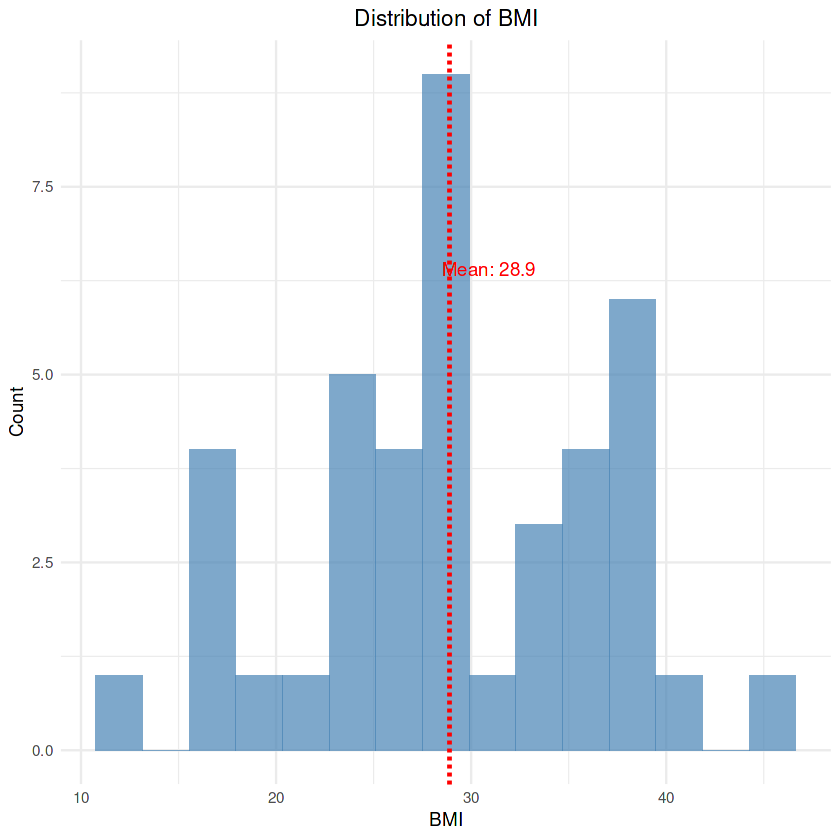

 Basic donor histograms displayed!


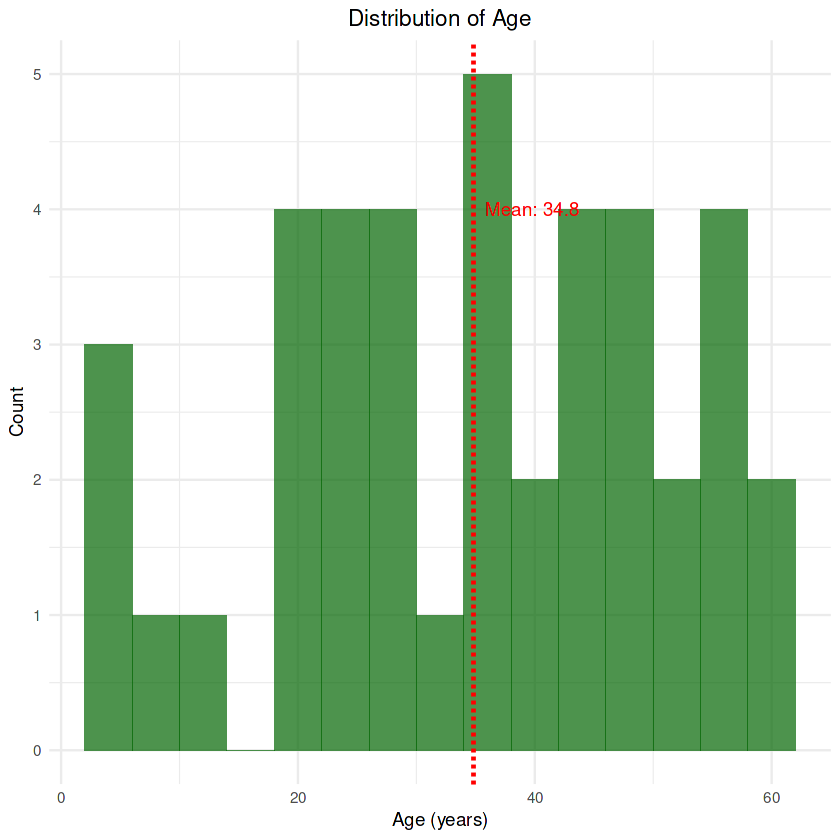

In [14]:
# Create donor demographics plots
cat(" Creating donor demographics visualizations...\n")

# BMI histogram
p1 <- ggplot(donor_metadata, aes(x = bmi)) +
  geom_histogram(bins = HISTOGRAM_BINS, fill = "steelblue", alpha = PLOT_ALPHA) +
  labs(title = "Distribution of BMI", x = "BMI", y = "Count") +
  geom_vline(aes(xintercept = mean(bmi, na.rm = TRUE)), color = "red", linetype = "dashed", size = 1) +
  annotate("text", x = mean(donor_metadata$bmi, na.rm = TRUE) + 2, 
           y = max(table(cut(donor_metadata$bmi, HISTOGRAM_BINS))) * 0.8,
           label = paste("Mean:", round(mean(donor_metadata$bmi, na.rm = TRUE), 1)), color = "red")

print(p1)

# Age histogram  
p2 <- ggplot(donor_metadata, aes(x = age)) +
  geom_histogram(bins = HISTOGRAM_BINS, fill = "darkgreen", alpha = PLOT_ALPHA) +
  labs(title = "Distribution of Age", x = "Age (years)", y = "Count") +
  geom_vline(aes(xintercept = mean(age, na.rm = TRUE)), color = "red", linetype = "dashed", size = 1) +
  annotate("text", x = mean(donor_metadata$age, na.rm = TRUE) + 5, 
           y = max(table(cut(donor_metadata$age, HISTOGRAM_BINS))) * 0.8,
           label = paste("Mean:", round(mean(donor_metadata$age, na.rm = TRUE), 1)), color = "red")

print(p2)

cat(" Basic donor histograms displayed!\n")

### Donor Categorical Demographics

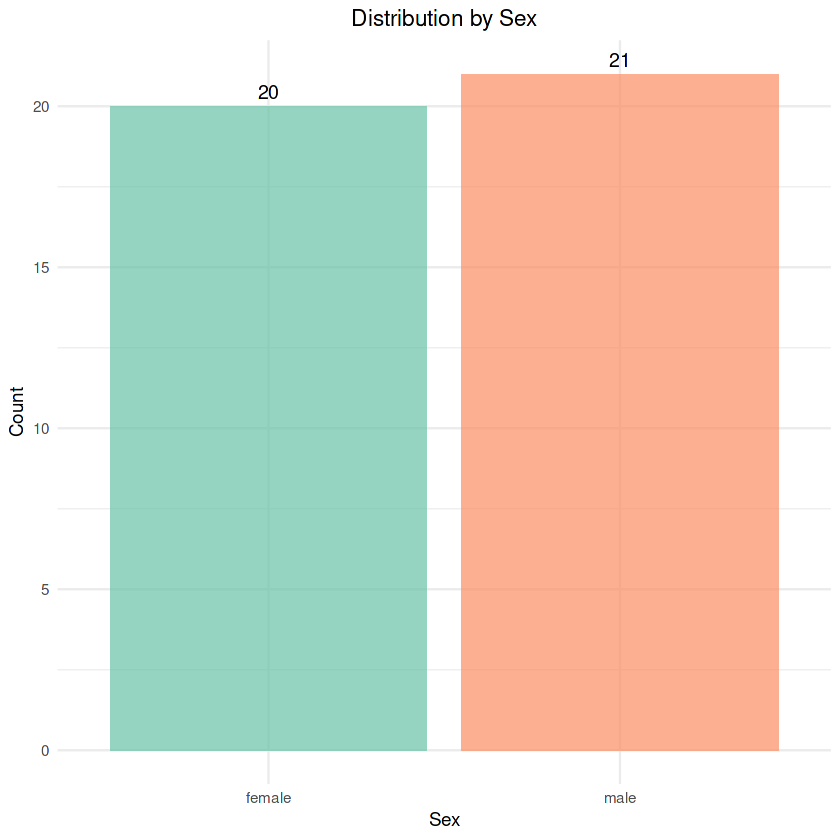

 Donor Demographics Summary:
Age: Mean = 34.8 , SD = 15.9 
BMI: Mean = 28.9 , SD = 7.7 
 Categorical demographic plots displayed!


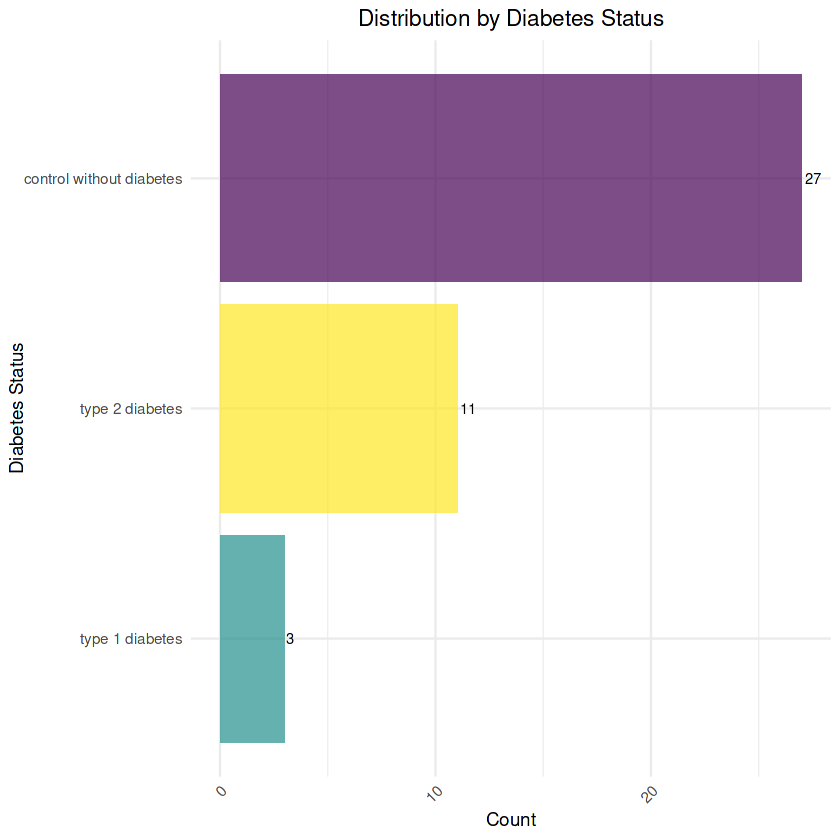

In [15]:
# Sex distribution
sex_counts <- table(donor_metadata$sex)
p3 <- ggplot(data.frame(sex = names(sex_counts), count = as.numeric(sex_counts)), 
             aes(x = sex, y = count, fill = sex)) +
  geom_bar(stat = "identity", alpha = PLOT_ALPHA) +
  geom_text(aes(label = count), vjust = -0.5, size = 4) +
  labs(title = "Distribution by Sex", x = "Sex", y = "Count") +
  scale_fill_brewer(type = "qual", palette = COLOR_PALETTE) +
  theme(legend.position = "none")

print(p3)

# Diabetes status distribution
diabetes_counts <- table(donor_metadata$diabetes_status_description, useNA = "ifany")
p4 <- ggplot(data.frame(status = names(diabetes_counts), count = as.numeric(diabetes_counts)), 
             aes(x = reorder(status, count), y = count, fill = status)) +
  geom_bar(stat = "identity", alpha = PLOT_ALPHA) +
  geom_text(aes(label = count), hjust = -0.2, size = 3) +
  labs(title = "Distribution by Diabetes Status", x = "Diabetes Status", y = "Count") +
  scale_fill_viridis_d() +
  theme(legend.position = "none", axis.text.x = element_text(angle = 45, hjust = 1)) +
  coord_flip()

print(p4)

# Summary statistics
cat(" Donor Demographics Summary:\n")
cat("Age: Mean =", round(mean(donor_metadata$age, na.rm = TRUE), 1), 
    ", SD =", round(sd(donor_metadata$age, na.rm = TRUE), 1), "\n")
cat("BMI: Mean =", round(mean(donor_metadata$bmi, na.rm = TRUE), 1), 
    ", SD =", round(sd(donor_metadata$bmi, na.rm = TRUE), 1), "\n")

cat(" Categorical demographic plots displayed!\n")

### Donor Correlation Analysis

In [ ]:
if(INCLUDE_CORRELATIONS) {
  cat(" Performing correlation analysis...\n")
  
  # BMI vs HbA1c scatter plot
  p5 <- ggplot(donor_metadata, aes(x = bmi, y = hba1c, color = sex)) +
    geom_point(size = PLOT_SIZE, alpha = PLOT_ALPHA) +
    geom_smooth(method = "lm", se = TRUE, alpha = 0.3) +
    labs(title = "BMI vs HbA1c by Sex", 
         x = "BMI", y = "HbA1c (%)", color = "Sex") +
    scale_color_brewer(type = "qual", palette = COLOR_PALETTE)
  
  print(p5)
  
  # Calculate correlations
  cor_result <- cor.test(donor_metadata$bmi, donor_metadata$hba1c, use = "complete.obs")
  cat(" BMI vs HbA1c correlation:\n")
  cat("   • Correlation coefficient:", round(cor_result$estimate, 3), "\n")
  cat("   • P-value:", round(cor_result$p.value, 4), "\n")
  cat("   • Significance:", ifelse(cor_result$p.value < 0.05, "Significant", "Not significant"), "\n")
  
  # Age vs other variables
  if(sum(!is.na(donor_metadata$age) & !is.na(donor_metadata$c_peptide)) > 3) {
    cor_age_cpep <- cor.test(donor_metadata$age, donor_metadata$c_peptide, use = "complete.obs")
    cat(" Age vs C-peptide correlation:\n")
    cat("   • Correlation coefficient:", round(cor_age_cpep$estimate, 3), "\n")
    cat("   • P-value:", round(cor_age_cpep$p.value, 4), "\n")
  }
  
  cat(" Correlation analysis complete!\n")
} else {
  cat("  Correlation analysis skipped (INCLUDE_CORRELATIONS = FALSE)\n")
}

### Sample Quality Visualizations

 Creating sample quality visualizations...


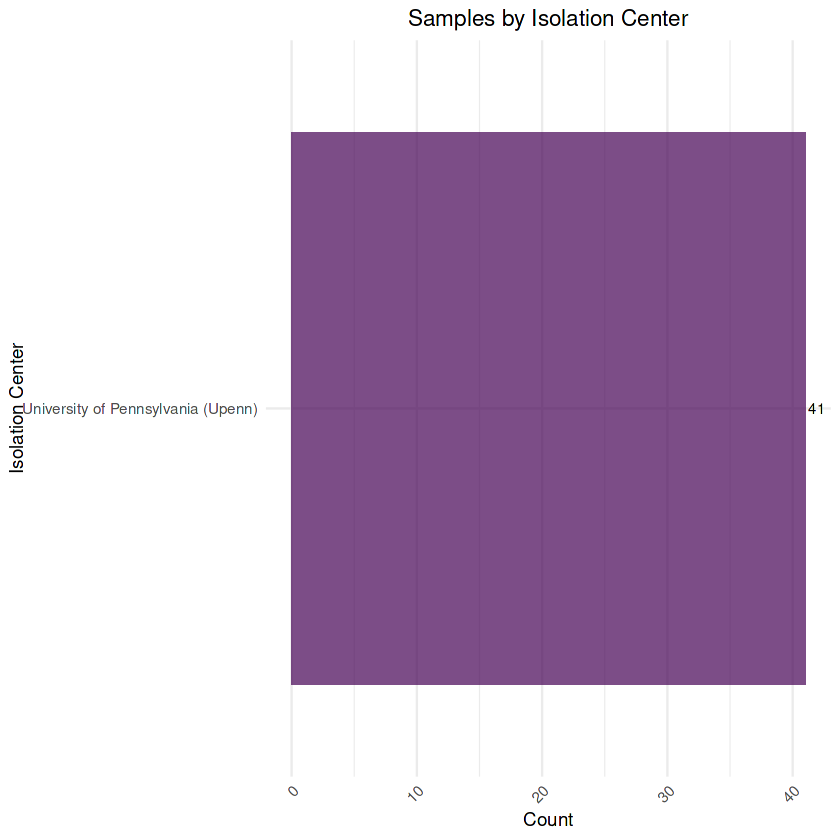

 Sample quality plots displayed!


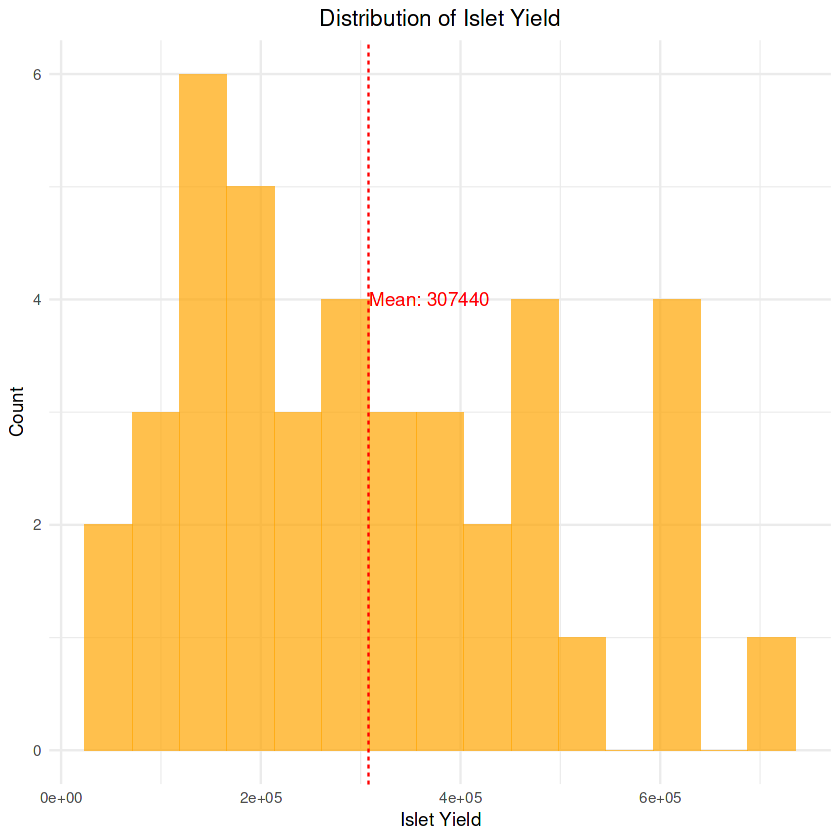

In [17]:
# Sample quality and characteristics plots
cat(" Creating sample quality visualizations...\n")

# Isolation center distribution
center_counts <- table(sample_metadata$isolation_center, useNA = "ifany")
# Filter centers with minimum sample size if specified
if(MIN_SAMPLE_SIZE > 1) {
  center_counts <- center_counts[center_counts >= MIN_SAMPLE_SIZE]
}

p6 <- ggplot(data.frame(center = names(center_counts), count = as.numeric(center_counts)), 
             aes(x = reorder(center, count), y = count, fill = center)) +
  geom_bar(stat = "identity", alpha = PLOT_ALPHA) +
  geom_text(aes(label = count), hjust = -0.2, size = 3) +
  labs(title = "Samples by Isolation Center", x = "Isolation Center", y = "Count") +
  scale_fill_viridis_d() +
  theme(legend.position = "none", axis.text.x = element_text(angle = 45, hjust = 1)) +
  coord_flip()

print(p6)

# Islet yield histogram
p7 <- ggplot(sample_metadata, aes(x = islet_yield)) +
  geom_histogram(bins = HISTOGRAM_BINS, fill = "orange", alpha = PLOT_ALPHA) +
  labs(title = "Distribution of Islet Yield", x = "Islet Yield", y = "Count") +
  geom_vline(aes(xintercept = mean(islet_yield, na.rm = TRUE)), color = "red", linetype = "dashed") +
  annotate("text", x = mean(sample_metadata$islet_yield, na.rm = TRUE) * 1.2, 
           y = max(table(cut(sample_metadata$islet_yield, HISTOGRAM_BINS)), na.rm = TRUE) * 0.8,
           label = paste("Mean:", round(mean(sample_metadata$islet_yield, na.rm = TRUE), 0)), color = "red")

print(p7)

cat(" Sample quality plots displayed!\n")

### Sample Viability & Technical Metrics

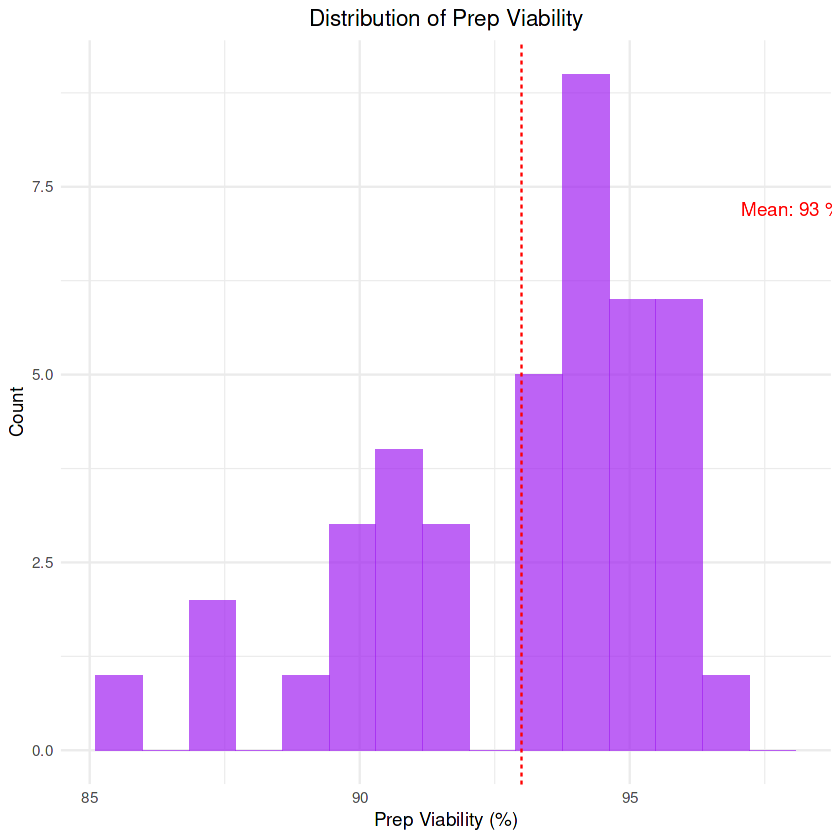

 Cold ischemia time distribution displayed
 Sample Quality Summary:
Islet Yield: Mean = 307440 , SD = 176550 
Prep Viability: Mean = 93 % , SD = 2.7 %
 Sample technical metrics displayed!


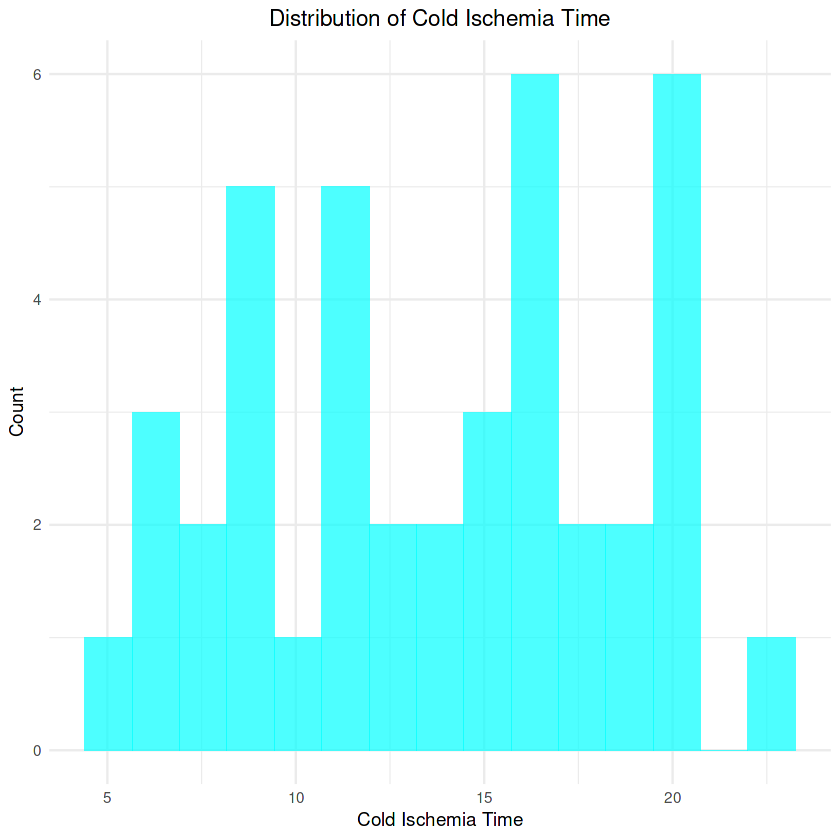

In [18]:
# Prep viability histogram
p8 <- ggplot(sample_metadata, aes(x = prep_viability)) +
  geom_histogram(bins = HISTOGRAM_BINS, fill = "purple", alpha = PLOT_ALPHA) +
  labs(title = "Distribution of Prep Viability", x = "Prep Viability (%)", y = "Count") +
  geom_vline(aes(xintercept = mean(prep_viability, na.rm = TRUE)), color = "red", linetype = "dashed") +
  annotate("text", x = mean(sample_metadata$prep_viability, na.rm = TRUE) + 5, 
           y = max(table(cut(sample_metadata$prep_viability, HISTOGRAM_BINS)), na.rm = TRUE) * 0.8,
           label = paste("Mean:", round(mean(sample_metadata$prep_viability, na.rm = TRUE), 1), "%"), color = "red")

print(p8)

# Cold ischemia time if available
if(sum(!is.na(sample_metadata$cold_ischaemia_time)) > 5) {
  p9 <- ggplot(sample_metadata, aes(x = cold_ischaemia_time)) +
    geom_histogram(bins = HISTOGRAM_BINS, fill = "cyan", alpha = PLOT_ALPHA) +
    labs(title = "Distribution of Cold Ischemia Time", x = "Cold Ischemia Time", y = "Count")
  
  print(p9)
  cat(" Cold ischemia time distribution displayed\n")
}

# Sample quality summary statistics
cat(" Sample Quality Summary:\n")
cat("Islet Yield: Mean =", round(mean(sample_metadata$islet_yield, na.rm = TRUE), 0), 
    ", SD =", round(sd(sample_metadata$islet_yield, na.rm = TRUE), 0), "\n")
cat("Prep Viability: Mean =", round(mean(sample_metadata$prep_viability, na.rm = TRUE), 1), "%", 
    ", SD =", round(sd(sample_metadata$prep_viability, na.rm = TRUE), 1), "%\n")

cat(" Sample technical metrics displayed!\n")

## Option 1
### READ RDS object and make plots using simple URL connection (most reliable for open access) no local download needed
File: https://data.pankbase.org/matrix-files/PKBFI0784JPQV

https://pankbase-data-v1.s3.us-west-2.amazonaws.com/analysis_resources/single_cell_objects/PanKbase_snatac_v1.rds

- No local storage required - Saves disk space (important for a ~10GB file)
- Faster start - No download wait time
- Memory efficient - File is streamed directly into R's memory
- Always current - You're always accessing the latest version

#### Important Considerations:

- Memory Requirements - The file will still consume ~10GB of RAM when loaded
- Network Stability - Streaming large files requires a stable internet connection
- Timeout Settings - Large files need extended timeout periods
- Error Handling - Network issues can interrupt the process

In [12]:
rds_url <- "https://pankbase-data-v1.s3.us-west-2.amazonaws.com/analysis_resources/single_cell_objects/PanKbase_snatac_v1.rds"
seurat_obj <- NULL

if (is.null(seurat_obj)) {
  cat("Trying direct URL connection with extended timeout...\n")
  
  # Set longer timeout (1 hour = 3600 seconds)
  options(timeout = 3600)
  
  loading_time <- system.time({
    tryCatch({
      seurat_obj <- readRDS(url(rds_url, open = "rb"))
      cat("✓ Success with direct URL method!\n")
    }, error = function(e) {
      cat("✗ Direct URL failed:", e$message, "\n")
    })
  })
  
  if (!is.null(seurat_obj)) {
    cat("Loading time:", loading_time["elapsed"], "seconds\n")
    cat("Loading time:", round(loading_time["elapsed"]/60, 1), "minutes\n")
  }
}

Trying direct URL connection with extended timeout...
✓ Success with direct URL method!
Loading time: 1880.667 seconds
Loading time: 31.3 minutes


In [ ]:
if (exists("seurat_obj") && !is.null(seurat_obj)) {
  cat("=== SEURAT OBJECT ANALYSIS ===\n")
  
  # Check available reductions
  cat("Available dimensional reductions:\n")
  print(names(seurat_obj@reductions))
  
  # Check metadata columns
  cat("\nMetadata columns:\n")
  print(colnames(seurat_obj@meta.data))
  
  # Display first few rows of metadata
  cat("\nFirst few rows of cell metadata:\n")
  print(head(seurat_obj@meta.data))
  
  # Check if UMAP coordinates exist
  if ("umap" %in% names(seurat_obj@reductions)) {
    cat("\nUMAP coordinates are available!\n")
    umap_coords <- Embeddings(seurat_obj, reduction = "umap")
    cat("UMAP dimensions:", dim(umap_coords), "\n")
  } else {
    cat("\nUMAP coordinates not found. Available reductions:", names(seurat_obj@reductions), "\n")
  }
  
} else {
  cat("Seurat object not available for analysis.\n")
}

Loading required package: Signac



Found cluster information in: seurat_clusters 


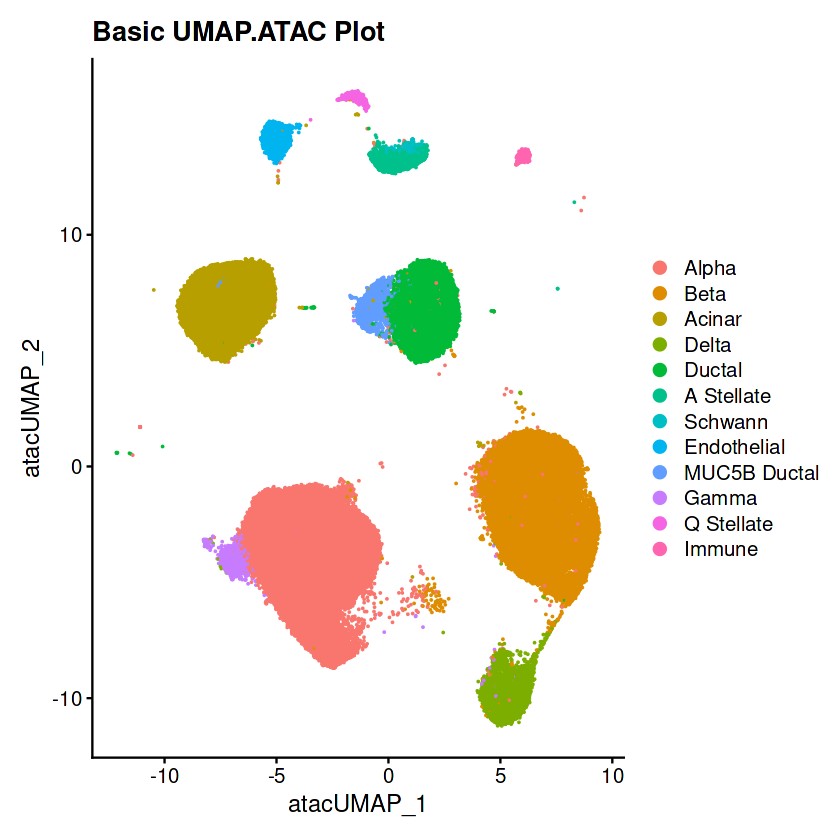

Found cell type information in: Cell.Type 


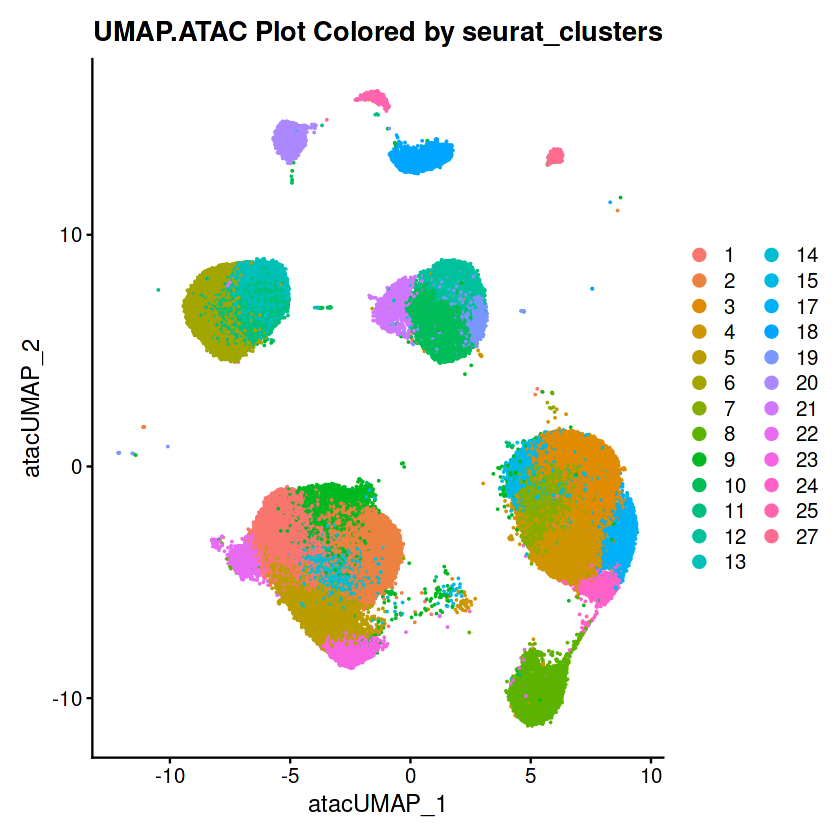

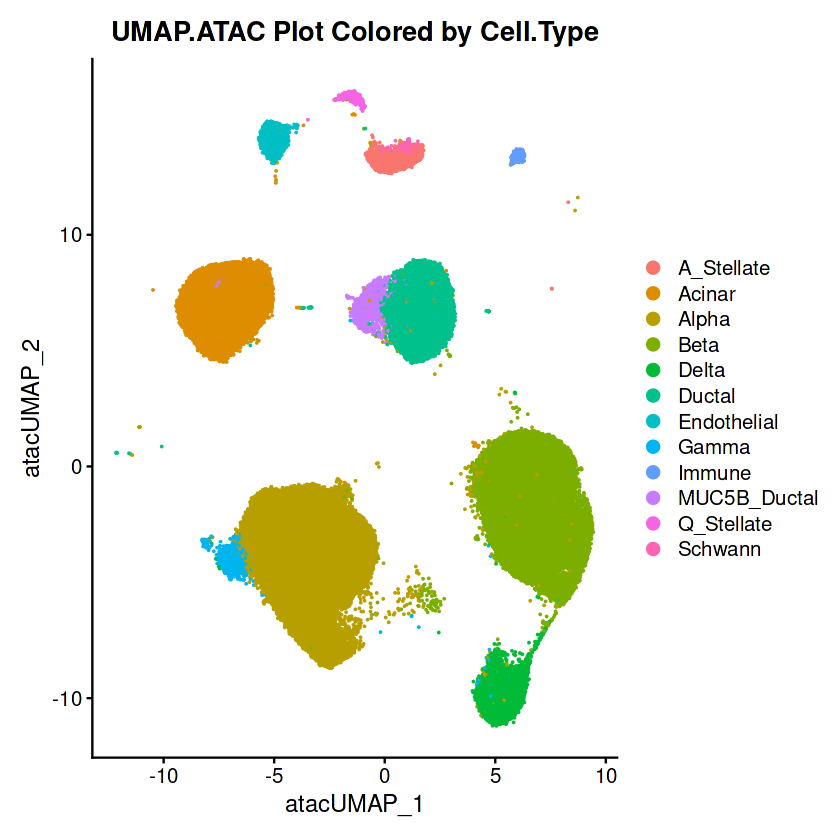

In [14]:
if (exists("seurat_obj") && !is.null(seurat_obj)) {
  
  # Check for UMAP or other reductions
  if ("umap.atac" %in% names(seurat_obj@reductions)) {
    reduction_to_use <- "umap.atac"
  } else if ("tsne" %in% names(seurat_obj@reductions)) {
    reduction_to_use <- "tsne"
    cat("UMAP not available, using t-SNE instead.\n")
  } else if (length(names(seurat_obj@reductions)) > 0) {
    reduction_to_use <- names(seurat_obj@reductions)[1]
    cat("Using first available reduction:", reduction_to_use, "\n")
  } else {
    cat("No dimensional reductions available in the object.\n")
    reduction_to_use <- NULL
  }
  
  if (!is.null(reduction_to_use)) {
    # Basic UMAP/reduction plot
    p_basic <- DimPlot(seurat_obj, reduction = reduction_to_use) +
      ggtitle(paste("Basic", toupper(reduction_to_use), "Plot"))
    print(p_basic)
    
    # Check for clustering information
    cluster_cols <- grep("cluster|seurat_clusters", colnames(seurat_obj@meta.data), 
                        value = TRUE, ignore.case = TRUE)
    
    if (length(cluster_cols) > 0) {
      cat("Found cluster information in:", cluster_cols[1], "\n")
      p_cluster <- DimPlot(seurat_obj, reduction = reduction_to_use, 
                          group.by = cluster_cols[1]) +
        ggtitle(paste(toupper(reduction_to_use), "Plot Colored by", cluster_cols[1]))
      print(p_cluster)
    }
    
    # Check for cell type annotations
    celltype_cols <- grep("cell.type|celltype|annotation", colnames(seurat_obj@meta.data), 
                         value = TRUE, ignore.case = TRUE)
    
    if (length(celltype_cols) > 0) {
      cat("Found cell type information in:", celltype_cols[1], "\n")
      p_celltype <- DimPlot(seurat_obj, reduction = reduction_to_use, 
                           group.by = celltype_cols[1]) +
        ggtitle(paste(toupper(reduction_to_use), "Plot Colored by", celltype_cols[1]))
      print(p_celltype)
    }
  }
  
} else {
  cat("Cannot create UMAP plot - Seurat object not available.\n")
}

## Option 2 
### Local Download Method 

- Persistent local copy - File remains available for future use
- Resumable downloads - Can continue interrupted downloads with proper tools
- Offline access - Work with data without internet connection
- Reliable loading - Once downloaded, loading is fast and reliable
- Progress tracking - Can monitor download progress with curl/wget

Important Considerations:

- Storage requirements - Requires ~10GB of local disk space
- Two-step process - Download time + loading time
- Disk I/O overhead - Additional read/write operations
- Storage management - Need to clean up large files manually
- Slower initial access - Must complete download before analysis

In [16]:
# Download and load the RDS file with better handling for large files
rds_url <- "https://pankbase-data-v1.s3.us-west-2.amazonaws.com/analysis_resources/single_cell_objects/PanKbase_snatac_v1.rds"
local_file <- "seurat_object.Rds"

cat("Attempting to download large RDS file (~10GB)...\n")
cat("This may take several minutes depending on your internet connection.\n")

# Function to download large files with progress and better timeout handling
download_large_file <- function(url, destfile, timeout = 3600) {
  tryCatch({
    # Set longer timeout for large files (1 hour)
    options(timeout = timeout)
    
    # Try downloading with curl if available (better for large files)
    if (Sys.which("curl") != "") {
      cat("Using curl for download...\n")
      system_command <- sprintf('curl -L -o "%s" "%s"', destfile, url)
      result <- system(system_command)
      
      if (result == 0 && file.exists(destfile)) {
        return(TRUE)
      } else {
        cat("Curl download failed, trying R download.file...\n")
      }
    }
    
    # Fallback to R's download.file with extended timeout
    cat("Using R download.file with extended timeout...\n")
    download.file(url, destfile = destfile, mode = "wb", timeout = timeout)
    
    if (file.exists(destfile)) {
      return(TRUE)
    } else {
      return(FALSE)
    }
    
  }, error = function(e) {
    cat("Download error:", e$message, "\n")
    return(FALSE)
  })
}

# Attempt download with timing
cat("Starting download...\n")
download_time <- system.time({
  download_success <- download_large_file(rds_url, local_file, timeout = 3600)
})

if (download_success && file.exists(local_file)) {
  cat("Download completed successfully!\n")
  cat("Download time:", download_time["elapsed"], "seconds\n")
  cat("Download time:", round(download_time["elapsed"]/60, 1), "minutes\n")
  
  file_size <- file.info(local_file)$size
  cat("File size:", round(file_size / 1024^3, 2), "GB\n")
  
  # Calculate download speed
  speed_mbps <- (file_size / 1024^2) / download_time["elapsed"]
  cat("Average download speed:", round(speed_mbps, 1), "MB/s\n")
  
  # Load the Seurat object with timing
  cat("Loading Seurat object (this may take a few minutes)...\n")
  loading_time <- system.time({
    tryCatch({
      seurat_obj <- readRDS(local_file)
      cat("Seurat object loaded successfully!\n")
      cat("Number of cells:", ncol(seurat_obj), "\n")
      cat("Number of features:", nrow(seurat_obj), "\n")
      print(seurat_obj)
      
    }, error = function(e) {
      cat("Error loading RDS file:", e$message, "\n")
      cat("The file may be corrupted or incomplete.\n")
      seurat_obj <- NULL
    })
  })
  
  if (!is.null(seurat_obj)) {
    cat("Loading time:", loading_time["elapsed"], "seconds\n") 
    cat("Loading time:", round(loading_time["elapsed"]/60, 1), "minutes\n")
    cat("Total time (download + load):", round((download_time["elapsed"] + loading_time["elapsed"])/60, 1), "minutes\n")
  }
  
} else {
  cat("Download failed. The file is very large (~10GB) and may require:\n")
  cat("1. A stable, fast internet connection\n")
  cat("2. Sufficient disk space\n")
  cat("3. Extended time (potentially 30+ minutes)\n\n")
  
  cat("Alternative approaches:\n")
  cat("1. Download manually using a download manager\n")
  cat("2. Use command line: wget or curl\n")
  cat("3. Download in parts if the server supports range requests\n\n")
  
  # Try to get file metadata without downloading
  cat("Attempting to get file information...\n")
  tryCatch({
    response <- HEAD(rds_url)
    if (status_code(response) == 200) {
      headers <- headers(response)
      if ("content-length" %in% names(headers)) {
        size_bytes <- as.numeric(headers$`content-length`)
        size_gb <- round(size_bytes / 1024^3, 2)
        cat("Confirmed file size:", size_gb, "GB\n")
      }
      if ("last-modified" %in% names(headers)) {
        cat("Last modified:", headers$`last-modified`, "\n")
      }
    }
  }, error = function(e) {
    cat("Could not retrieve file metadata\n")
  })
  
  seurat_obj <- NULL
}

Attempting to download large RDS file (~10GB)...
This may take several minutes depending on your internet connection.
Starting download...
Using curl for download...
Download completed successfully!
Download time: 1163.727 seconds
Download time: 19.4 minutes
File size: 23.29 GB
Average download speed: 20.5 MB/s
Loading Seurat object (this may take a few minutes)...
Seurat object loaded successfully!
Number of cells: 97837 
Number of features: 481311 
An object of class Seurat 
1303997 features across 97837 samples within 4 assays 
Active assay: ATAC_peaks (481311 features, 481311 variable features)
 2 layers present: counts, data
 3 other assays present: RNA, Final_Peaks, Unified_Peaks
 3 dimensional reductions calculated: lsi, harmony.atac, umap.atac
Loading time: 467.618 seconds
Loading time: 7.8 minutes
Total time (download + load): 27.2 minutes


In [ ]:
if (exists("seurat_obj") && !is.null(seurat_obj)) {
  cat("=== SEURAT OBJECT ANALYSIS ===\n")
  
  # Check available reductions
  cat("Available dimensional reductions:\n")
  print(names(seurat_obj@reductions))
  
  # Check metadata columns
  cat("\nMetadata columns:\n")
  print(colnames(seurat_obj@meta.data))
  
  # Display first few rows of metadata
  cat("\nFirst few rows of cell metadata:\n")
  print(head(seurat_obj@meta.data))
  
  # Check if UMAP coordinates exist
  if ("umap" %in% names(seurat_obj@reductions)) {
    cat("\nUMAP coordinates are available!\n")
    umap_coords <- Embeddings(seurat_obj, reduction = "umap")
    cat("UMAP dimensions:", dim(umap_coords), "\n")
  } else {
    cat("\nUMAP coordinates not found. Available reductions:", names(seurat_obj@reductions), "\n")
  }
  
} else {
  cat("Seurat object not available for analysis.\n")
}

Found cluster information in: seurat_clusters 


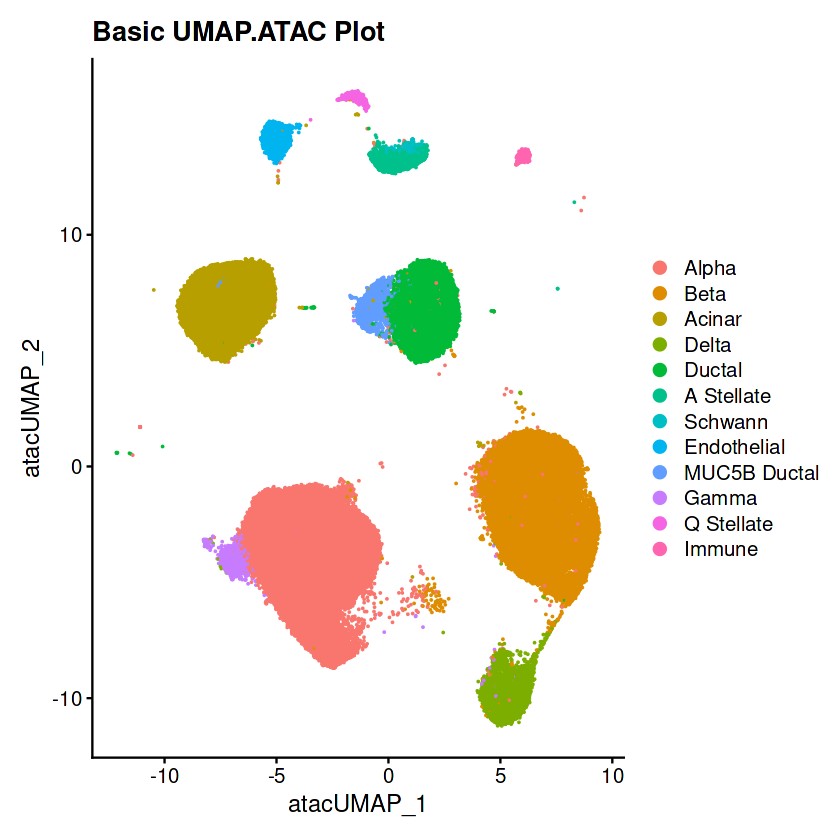

Found cell type information in: Cell.Type 


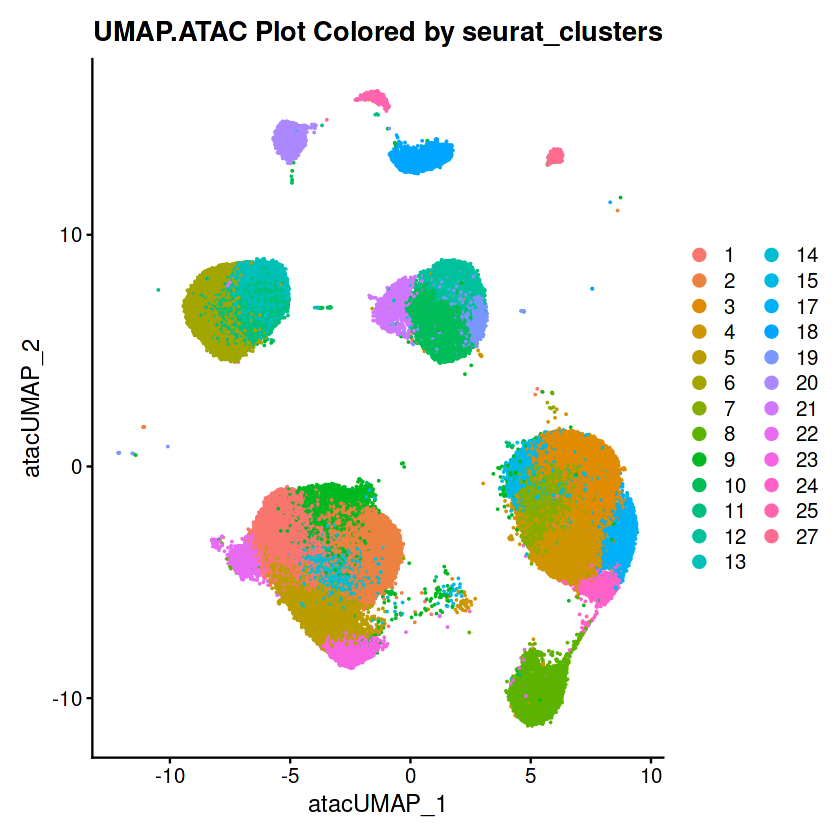

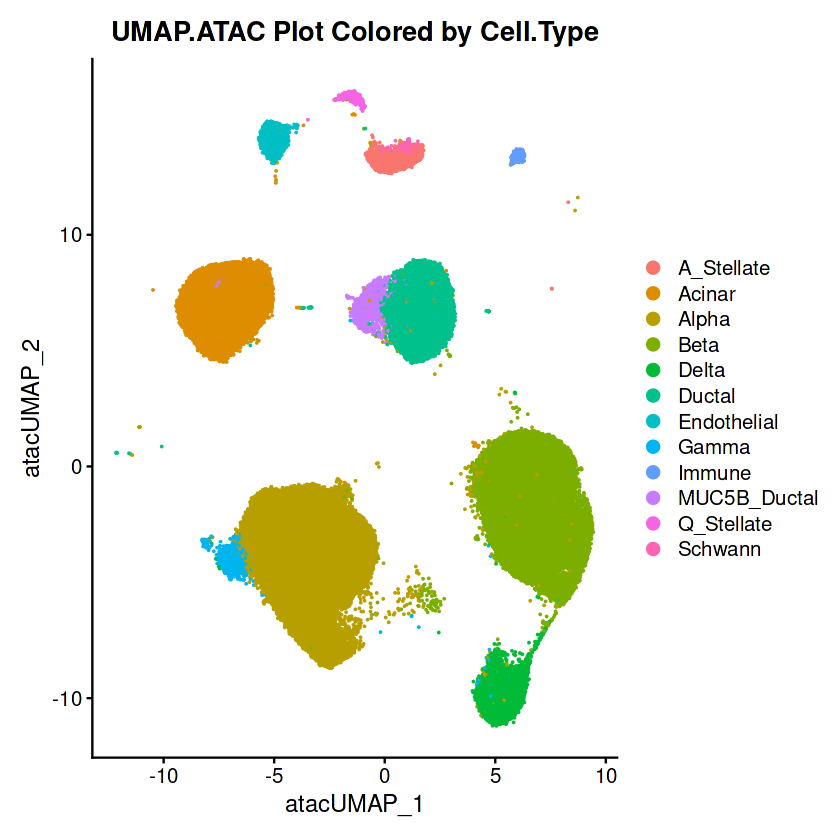

In [18]:
if (exists("seurat_obj") && !is.null(seurat_obj)) {
  
  # Check for UMAP or other reductions
  if ("umap.atac" %in% names(seurat_obj@reductions)) {
    reduction_to_use <- "umap.atac"
  } else if ("tsne" %in% names(seurat_obj@reductions)) {
    reduction_to_use <- "tsne"
    cat("UMAP not available, using t-SNE instead.\n")
  } else if (length(names(seurat_obj@reductions)) > 0) {
    reduction_to_use <- names(seurat_obj@reductions)[1]
    cat("Using first available reduction:", reduction_to_use, "\n")
  } else {
    cat("No dimensional reductions available in the object.\n")
    reduction_to_use <- NULL
  }
  
  if (!is.null(reduction_to_use)) {
    # Basic UMAP/reduction plot
    p_basic <- DimPlot(seurat_obj, reduction = reduction_to_use) +
      ggtitle(paste("Basic", toupper(reduction_to_use), "Plot"))
    print(p_basic)
    
    # Check for clustering information
    cluster_cols <- grep("cluster|seurat_clusters", colnames(seurat_obj@meta.data), 
                        value = TRUE, ignore.case = TRUE)
    
    if (length(cluster_cols) > 0) {
      cat("Found cluster information in:", cluster_cols[1], "\n")
      p_cluster <- DimPlot(seurat_obj, reduction = reduction_to_use, 
                          group.by = cluster_cols[1]) +
        ggtitle(paste(toupper(reduction_to_use), "Plot Colored by", cluster_cols[1]))
      print(p_cluster)
    }
    
    # Check for cell type annotations
    celltype_cols <- grep("cell.type|celltype|annotation", colnames(seurat_obj@meta.data), 
                         value = TRUE, ignore.case = TRUE)
    
    if (length(celltype_cols) > 0) {
      cat("Found cell type information in:", celltype_cols[1], "\n")
      p_celltype <- DimPlot(seurat_obj, reduction = reduction_to_use, 
                           group.by = celltype_cols[1]) +
        ggtitle(paste(toupper(reduction_to_use), "Plot Colored by", celltype_cols[1]))
      print(p_celltype)
    }
  }
  
} else {
  cat("Cannot create UMAP plot - Seurat object not available.\n")
}

## Your downstream analysis starts here!!


### **Chromatin Accessibility Analyses**
- **Differential accessibility** - Find regions with condition-specific accessibility changes
- **Peak annotation** - Map accessible regions to genes (promoters, enhancers, gene bodies)
- **Motif enrichment** - Identify transcription factor binding sites in accessible regions
- **Chromatin state analysis** - Classify regulatory elements (active promoters, enhancers, etc.)
- **Accessibility dynamics** - Track opening/closing of chromatin regions

### **Gene Regulation Analyses**
- **Gene activity scoring** - Infer gene expression from promoter/gene body accessibility
- **Transcription factor analysis** - Predict TF activity using motif accessibility
- **Enhancer-promoter linking** - Connect distal regulatory elements to target genes
- **Regulatory network inference** - Build TF-target gene networks
- **Chromatin looping** - Analyze 3D chromatin interactions (if Hi-C data available)